In [ ]:
try:
    # Check if PyTorch Geometric is installed:
    import torch_geometric
except ImportError:
    # If PyTorch Geometric is not installed, install it.
    %pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
    %pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
    %pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.5 MB/s eta 0:00:00


# Graph Neural Networks 2: Design Space

The design space of GNNs is vast, and there are many different choices that can be made when designing a GNN. These choices include:

*   The type of graph convolution operation to use
*   The number of graph convolution layers
*   The activation function to use
*   The loss function to use
*   The optimization algorithm to use
*   The hyperparameters to tune
*   The choices that are made when designing a GNN can have a significant impact on the performance of the model. It is important to carefully consider the design choices when designing a GNN for a particular task.

In this lab, we will explore the design space of GNNs for node classification. We will evaluate the performance of the different models on the Cora dataset.

In [ ]:
import copy
from typing import Callable, Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import torch
import torch_geometric.transforms as T
from torch import Tensor
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Sequential
# from torch_geometric.utils import accuracy
from typing_extensions import Literal, TypedDict

In [ ]:
def accuracy(pred, target):
    r"""Computes the accuracy of predictions.

    Args:
        pred (Tensor): The predictions.
        target (Tensor): The targets.

    :rtype: int
    """
    return (pred == target).sum().item() / target.numel()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = Planetoid("/tmp/Cora", name="Cora", transform=T.NormalizeFeatures())
data = dataset[0].to(device)

Processing...
Done!


In [ ]:
LossFn = Callable[[Tensor, Tensor], Tensor]
Stage = Literal["train", "val", "test"]


def train_step(
    model: torch.nn.Module, data: Data, optimizer: torch.optim.Optimizer, loss_fn: LossFn
) -> Tuple[float, float]:
    model.train()
    optimizer.zero_grad()
    mask = data.train_mask
    logits = model(data.x, data.edge_index)[mask]
    preds = logits.argmax(dim=1)
    y = data.y[mask]
    loss = loss_fn(logits, y)
    acc = accuracy(preds, y)
    loss.backward()
    optimizer.step()
    return loss.item(), acc


@torch.no_grad()
def eval_step(model: torch.nn.Module, data: Data, loss_fn: LossFn, stage: Stage) -> Tuple[float, float]:
    model.eval()
    mask = getattr(data, f"{stage}_mask")
    logits = model(data.x, data.edge_index)[mask]
    preds = logits.argmax(dim=1)
    y = data.y[mask]
    loss = loss_fn(logits, y)
    acc = accuracy(preds, y)
    return loss.item(), acc

In [ ]:
class HistoryDict(TypedDict):
    loss: List[float]
    acc: List[float]
    val_loss: List[float]
    val_acc: List[float]


def train(
    model: torch.nn.Module,
    data: Data,
    optimizer: torch.optim.Optimizer,
    loss_fn: LossFn = torch.nn.CrossEntropyLoss(),
    max_epochs: int = 200,
    early_stopping: int = 10,
    print_interval: int = 20,
    verbose: bool = True,
) -> HistoryDict:
    history = {"loss": [], "val_loss": [], "acc": [], "val_acc": []}
    min_loss = float("inf")
    early_stopping_counter = 0
    for epoch in range(max_epochs):
        loss, acc = train_step(model, data, optimizer, loss_fn)
        val_loss, val_acc = eval_step(model, data, loss_fn, "val")
        history["loss"].append(loss)
        history["acc"].append(acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        # Early stopping
        if val_loss < min_loss:
            min_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter == early_stopping:
            if verbose:
                print("\nEarly stopping...")

            break

        if verbose and epoch % print_interval == 0:
            print(f"\nEpoch: {epoch}\n----------")
            print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
            print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")

    test_loss, test_acc = eval_step(model, data, loss_fn, "test")
    if verbose:
        print(f"\nEpoch: {epoch}\n----------")
        print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
        print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")
        print(f" Test loss: {test_loss:.4f} |  Test acc: {test_acc:.4f}")

    return history





In [ ]:
def plot_history(history: HistoryDict, title: str, font_size: Optional[int] = 14) -> None:
    plt.suptitle(title, fontsize=font_size)
    ax1 = plt.subplot(121)
    ax1.set_title("Loss")
    ax1.plot(history["loss"], label="train")
    ax1.plot(history["val_loss"], label="val")
    plt.xlabel("Epoch")
    ax1.legend()

    ax2 = plt.subplot(122)
    ax2.set_title("Accuracy")
    ax2.plot(history["acc"], label="train")
    ax2.plot(history["val_acc"], label="val")
    plt.xlabel("Epoch")
    ax2.legend()

In [ ]:
# Hyper parameters that we will not change during the experiments:
SEED = 42
HIDDEN_CHANNELS = 16
LEARNING_RATE = 0.01
WEIGHT_DECAY = 5e-4


torch.manual_seed(SEED)

# Classical GNN Layers: GCN

In [ ]:
from torch_geometric.nn import GCN


Epoch: 0
----------
Train loss: 2.7738 | Train acc: 0.0357
  Val loss: 2.7531 |   Val acc: 0.2540

Epoch: 20
----------
Train loss: 2.3776 | Train acc: 0.9857
  Val loss: 2.4399 |   Val acc: 0.6720

Epoch: 40
----------
Train loss: 2.1446 | Train acc: 0.9857
  Val loss: 2.2570 |   Val acc: 0.7000

Epoch: 60
----------
Train loss: 1.9971 | Train acc: 0.9786
  Val loss: 2.1405 |   Val acc: 0.7060

Epoch: 80
----------
Train loss: 1.8946 | Train acc: 0.9786
  Val loss: 2.0585 |   Val acc: 0.7160

Epoch: 100
----------
Train loss: 1.8194 | Train acc: 0.9714
  Val loss: 1.9974 |   Val acc: 0.7220

Epoch: 120
----------
Train loss: 1.7620 | Train acc: 0.9714
  Val loss: 1.9504 |   Val acc: 0.7420

Epoch: 140
----------
Train loss: 1.7172 | Train acc: 0.9714
  Val loss: 1.9132 |   Val acc: 0.7420

Epoch: 160
----------
Train loss: 1.6815 | Train acc: 0.9714
  Val loss: 1.8833 |   Val acc: 0.7380

Epoch: 180
----------
Train loss: 1.6524 | Train acc: 0.9786
  Val loss: 1.8589 |   Val acc: 0.7

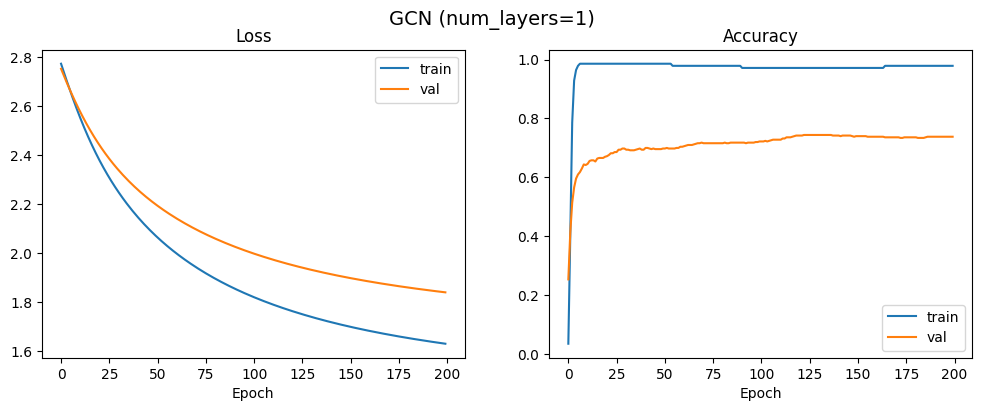

In [ ]:
NUM_LAYERS = 1


model = GCN(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GCN (num_layers={NUM_LAYERS})")

# Classical GNN Layers: GraphSAGE

## Why so many models?

*   The problem: the graphs in real world are dynamic

    \begin{equation}
        \left\vert G_{t_{0}}(V) \right\vert
        <
        \left\vert G_{t_{1}}(V) \right\vert
        <
        \ldots
        <
        \left\vert G_{t_{n}}(V) \right\vert
    \end{equation}

    i.e. the number of edges and/or vertices are time-dependent; we have an inductive model

*   The dimensionality of the matrix representation increases as well

    \begin{equation}
        A_{\left\vert V \right\vert \times d}
        \quad \xrightarrow{t=0} \quad
        A_{(\left\vert V \right\vert + k_{0})\times d}
        \quad \xrightarrow{t=1} \quad
        A_{(\left\vert V \right\vert + k_{1})\times d}
        \ldots
        \quad \xrightarrow{t=\tau} \quad
        A_{(\left\vert V \right\vert + k_{\tau})\times d}
    \end{equation}

    making the approach to not scale very well for large graphs, and very limited when generalizing to new graphs



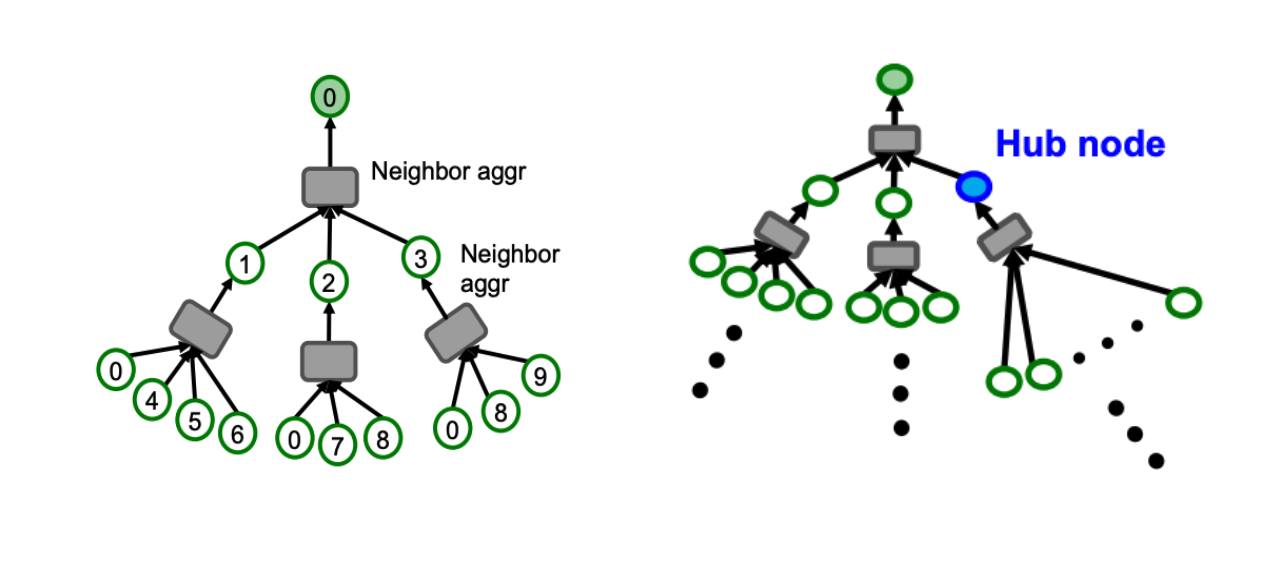

## Graph SAGE: SAmple & aggreGatE

>   The idea: as with large population models, it is sometimes impossible to track every single element of the population, so we sample it

How to do it (the short version):

>   *   Sample $k$ neighbours of a node
>   *   Now, you (literally) aggregate the information to end up with a single vector
>   *   Then label them or predict the structure of the graph

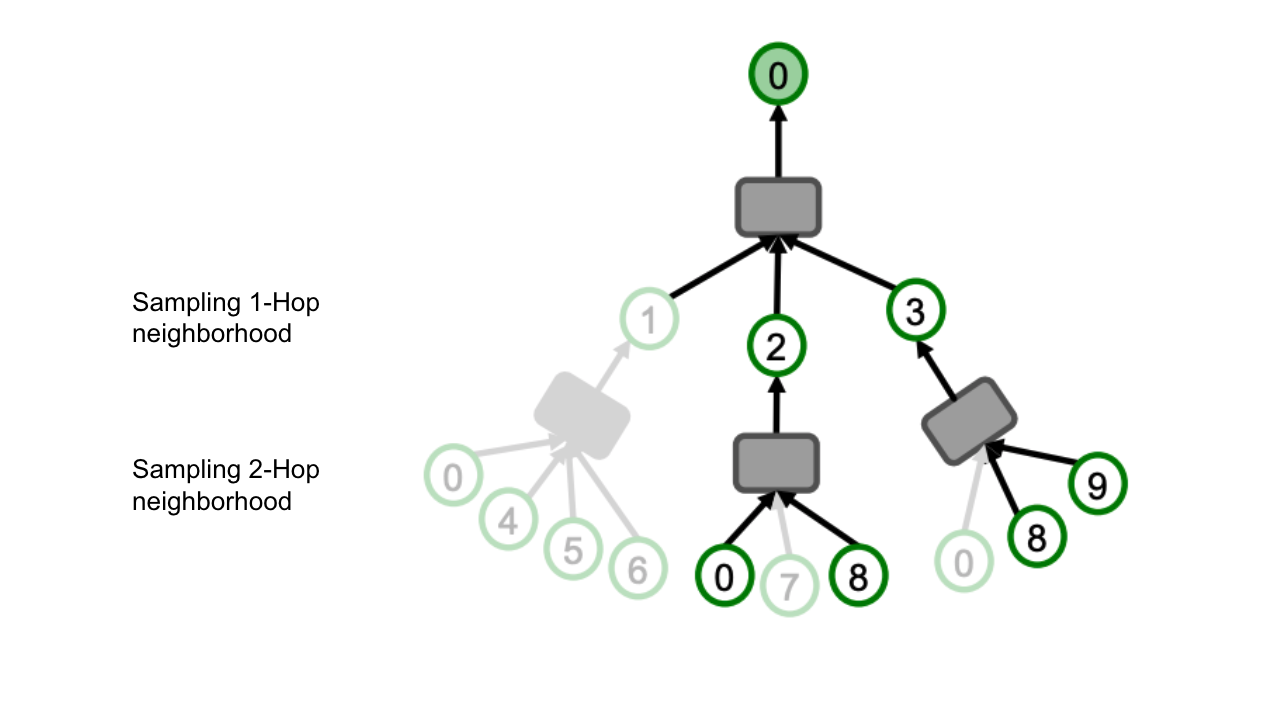


The inputs are

*   the graph $G(V, E)$
*   the input features $\left\lbrace x_{v} \in \mathcal{R}^{d} : v \in V \right\rbrace$
*   the depht $K$
*   the model parameters $W^{k}$ where $k = 1, 2, \ldots, K$
*   nonlinear function(s) $\sigma$
*   your differentiable aggregators $f_{k}$ where $k = 1, 2, \ldots, K$
*   your neighbors $N: v \rightarrow 2^{V}$

the output is

* a vector representation $z_{v}$ for all $v$ in $V$



1.  Set $x_{v} \rightarrow h_{v}^{0}$ for every node $v \in V$
2.  For $k=1,2,\ldots,K$ do
    
    *   for $v$ in $V$ do
    >   Aggregation: $f_{k}(h_{u}^{k-1}, \forall u \in N(v)) \rightarrow h_{N(v)}^{k}$ \\
    >   Nonlinearity: $\sigma(W^{k}, \left[h_{v}^{k-1}, h_{N(v)}^{k} \right]) \rightarrow h_{v}^{k}$

        Normalization: $
        \frac{h_{v}^{k}}{\left\vert\left\vert h_{v}^{k} \right\vert\right\vert_{2}} \rightarrow h_{v}^{k} \quad \forall v \in V
        $
3.  Return the vector representation $h_{v}^{K} \rightarrow z_{v} \forall v \in V$


## How to "aggregate" them?

* The mean aggregator:

    \begin{equation}
        \sigma(W \cdot \text{MEAN}\left( \left\lbrace h_{v}^{k-1} \right\rbrace \cup \left\lbrace h_{u}^{k-1} \text{ } \forall u \in N(v) \right\rbrace \right) )
        \quad \rightarrow \quad
        h_{v}^{k}
    \end{equation}

* The pooling aggregator:

    \begin{equation}
        \max\left( \left\lbrace \sigma\left(W_{\text{pool}}h_{u_{i}}^{k} + b\right) \text{ } \forall u_{i} \in N(v) \right\rbrace \right)
        \quad \rightarrow \quad
        h_{v}^{k}
    \end{equation}

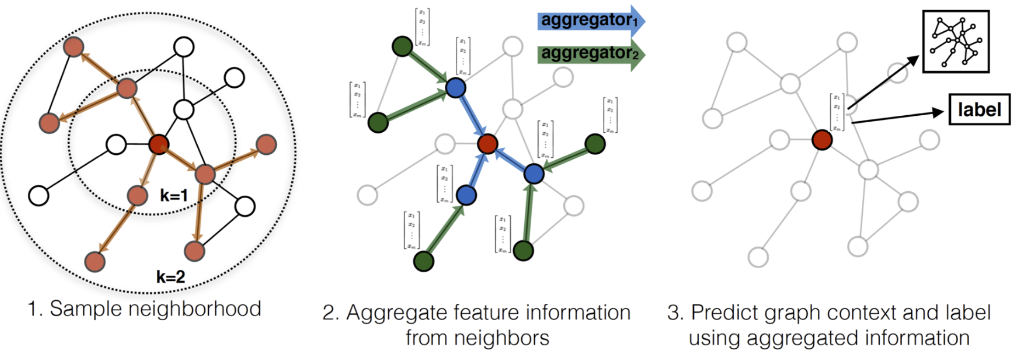

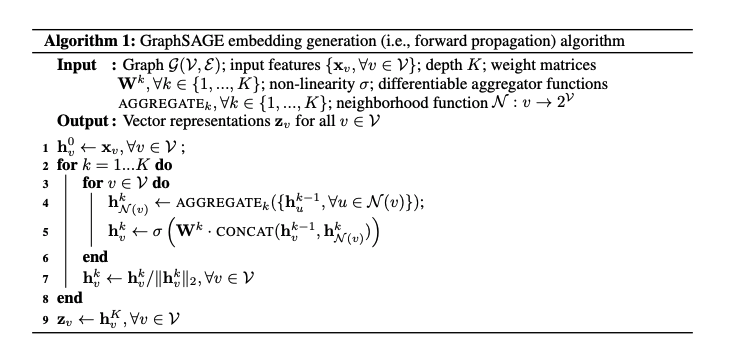

In [ ]:
from torch_geometric.nn import GraphSAGE


Epoch: 0
----------
Train loss: 2.7747 | Train acc: 0.0214
  Val loss: 2.7491 |   Val acc: 0.0900

Epoch: 20
----------
Train loss: 2.1259 | Train acc: 1.0000
  Val loss: 2.3364 |   Val acc: 0.6560

Epoch: 40
----------
Train loss: 1.7630 | Train acc: 1.0000
  Val loss: 2.1230 |   Val acc: 0.6760

Epoch: 60
----------
Train loss: 1.5441 | Train acc: 1.0000
  Val loss: 1.9931 |   Val acc: 0.6880

Epoch: 80
----------
Train loss: 1.4020 | Train acc: 1.0000
  Val loss: 1.9038 |   Val acc: 0.6880

Epoch: 100
----------
Train loss: 1.3050 | Train acc: 1.0000
  Val loss: 1.8388 |   Val acc: 0.6980

Epoch: 120
----------
Train loss: 1.2354 | Train acc: 1.0000
  Val loss: 1.7893 |   Val acc: 0.6960

Epoch: 140
----------
Train loss: 1.1834 | Train acc: 1.0000
  Val loss: 1.7504 |   Val acc: 0.6940

Epoch: 160
----------
Train loss: 1.1433 | Train acc: 1.0000
  Val loss: 1.7190 |   Val acc: 0.6900

Epoch: 180
----------
Train loss: 1.1118 | Train acc: 1.0000
  Val loss: 1.6931 |   Val acc: 0.6

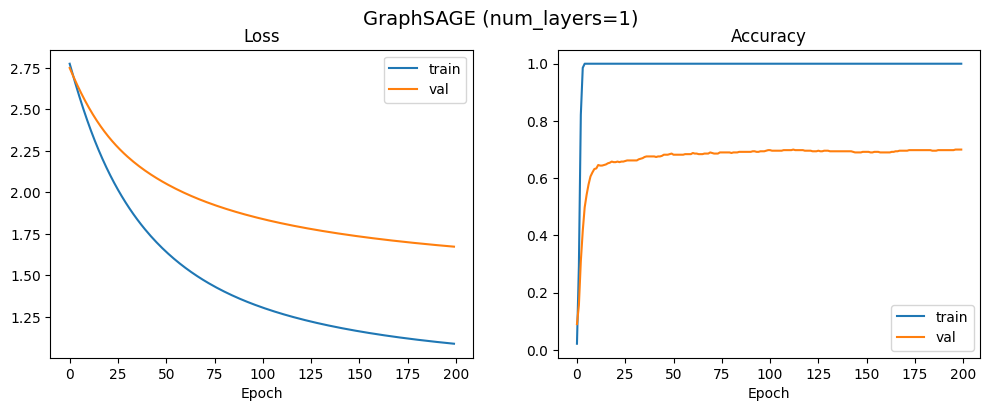

In [ ]:
NUM_LAYERS = 1


model = GraphSAGE(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GraphSAGE (num_layers={NUM_LAYERS})")

# GraphSAGE Neighbor Aggregation


Epoch: 0
----------
Train loss: 2.7715 | Train acc: 0.0214
  Val loss: 2.7191 |   Val acc: 0.3580

Epoch: 20
----------
Train loss: 1.5518 | Train acc: 1.0000
  Val loss: 2.0153 |   Val acc: 0.6840

Epoch: 40
----------
Train loss: 1.0535 | Train acc: 1.0000
  Val loss: 1.7261 |   Val acc: 0.7440

Epoch: 60
----------
Train loss: 0.8327 | Train acc: 1.0000
  Val loss: 1.5891 |   Val acc: 0.7380

Epoch: 80
----------
Train loss: 0.7180 | Train acc: 1.0000
  Val loss: 1.5082 |   Val acc: 0.7360

Epoch: 100
----------
Train loss: 0.6476 | Train acc: 1.0000
  Val loss: 1.4519 |   Val acc: 0.7420

Epoch: 120
----------
Train loss: 0.5990 | Train acc: 1.0000
  Val loss: 1.4094 |   Val acc: 0.7280

Epoch: 140
----------
Train loss: 0.5634 | Train acc: 1.0000
  Val loss: 1.3762 |   Val acc: 0.7280

Epoch: 160
----------
Train loss: 0.5364 | Train acc: 1.0000
  Val loss: 1.3496 |   Val acc: 0.7280

Epoch: 180
----------
Train loss: 0.5154 | Train acc: 1.0000
  Val loss: 1.3277 |   Val acc: 0.7

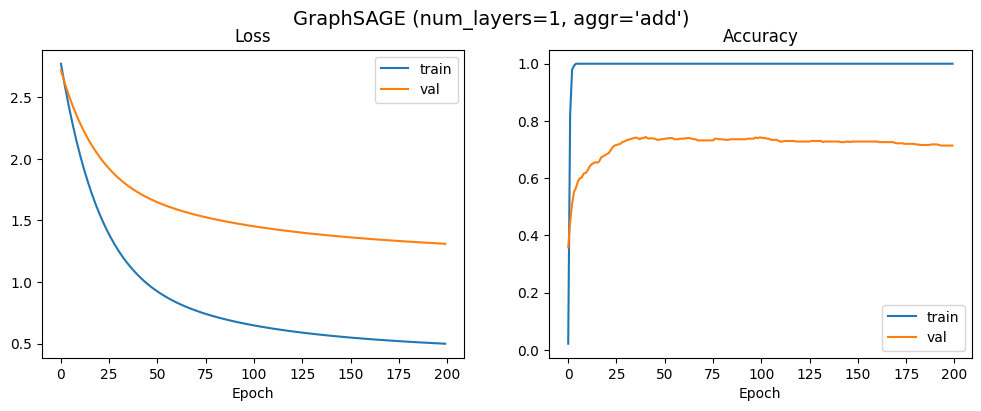

In [ ]:
NUM_LAYERS = 1
AGGR = "add"


model = GraphSAGE(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, aggr=AGGR).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GraphSAGE (num_layers={NUM_LAYERS}, aggr='{AGGR}')")

# GraphSAGE: L2 Normalization


Epoch: 0
----------
Train loss: 2.7091 | Train acc: 0.1286
  Val loss: 2.5201 |   Val acc: 0.2860

Epoch: 20
----------
Train loss: 1.8594 | Train acc: 1.0000
  Val loss: 2.2079 |   Val acc: 0.6940

Epoch: 40
----------
Train loss: 1.8488 | Train acc: 1.0000
  Val loss: 2.2050 |   Val acc: 0.6960

Early stopping...

Epoch: 43
----------
Train loss: 1.8483 | Train acc: 1.0000
  Val loss: 2.2027 |   Val acc: 0.6960
 Test loss: 2.2023 |  Test acc: 0.6890


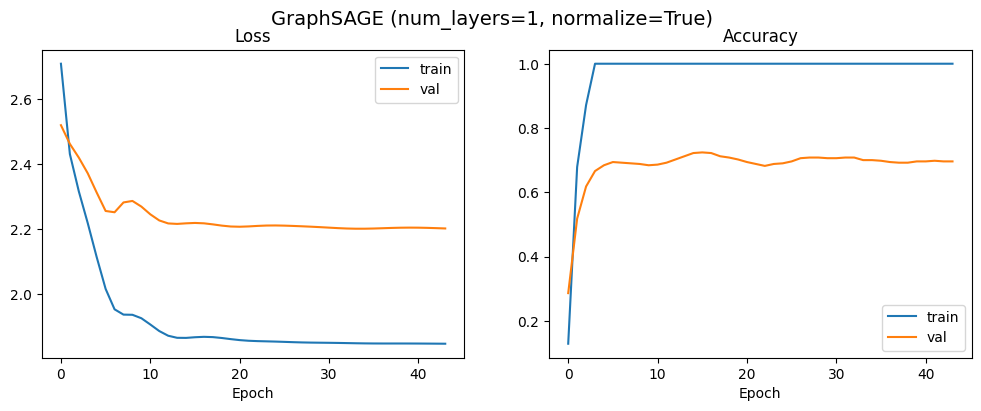

In [ ]:
NUM_LAYERS = 1
NORMALIZE = True


model = GraphSAGE(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, normalize=NORMALIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GraphSAGE (num_layers={NUM_LAYERS}, normalize={NORMALIZE})")

# Classical GNN Layers: GAT

## GAT: Graph ATtention Networks

Recall that in normal GCN we have

\begin{equation}
    h_{N(v)}
    =
    \frac{1}{\left\vert N(v) \right\vert}
    \sum_{u\in N(v)}
    w_{uv}h_{u}
\end{equation}

where the weights were (in many instances) some average of the number of connections of the node. Now the idea is to use a function to compute the weights

\begin{equation}
    h_{N(v)}
    =
    \frac{1}{\left\vert N(v) \right\vert}
    \sum_{u\in N(v)}
    \alpha(h_{u}, h_{v})
    h_{u}
\end{equation}

the function $\alpha$ considers

*   the embeddings of the source and the target nodes
*   this adds more information than just the number of neighbors
*   ths allows to incorporate features or graph-related structures
*   this function $\alpha$ is referred to as the attention function, since it allows to attend some neighbors more than others
*   normally it is presented as

    \begin{equation}
        \alpha_{u,v}
        =
        \frac{ e^{\alpha(h_{u}, h_{v})} }{ \sum_{k\in N(v)} e^{\alpha(h_{u}, h_{v})} }
    \end{equation}



So far so good, but how are we going to compute the scores with the embeddings? We can use a neural network to do the job

\begin{equation}
    \alpha(h_{u}, h_{v})
    =
    \sigma\left(
    a^{T} \cdot \left[ Wh_{u} \vert \vert Wh_{v} \right]
    \right)
\end{equation}

where

*   $a^{T}$ and the $W$'s are the learning parameters
*   the operation $\left[ Wh_{u} \vert \vert Wh_{v} \right]$ defines concatenation for every embedding
*   $\sigma$ is the $\text{LeakyReLU}$

leading to

\begin{equation}
    \alpha(h_{u}, h_{v})
    =
    \text{LeakyReLU}\left(
    a^{T} \cdot \left[ Wh_{u} \vert \vert Wh_{v} \right]
    \right)
\end{equation}

thus

\begin{equation}
    \alpha_{u,v}
    =
    \frac{ e^{ \text{LeakyReLU}\left(
    a^{T} \cdot \left[ Wh_{u} \vert \vert Wh_{v} \right]
    \right) } }{ \sum_{k\in N(v)} e^{ \text{LeakyReLU}\left(
    a^{T} \cdot \left[ Wh_{u} \vert \vert Wh_{v} \right]
    \right) } }
\end{equation}

now, we have the attention mechanism

\begin{equation}
    h_{u}
    =
    \sigma\left(
    \sum_{v\in N(u)}
    \alpha_{uv} Wh_{v}
    \right)
\end{equation}

and, if at the end we have multi headed attention

\begin{equation}
    h_{u}
    =
    \left\vert\left\vert_{k=1}^{K}
    \sigma
    \left(
    \sum_{v\in N(u)}
    \alpha_{uv} Wh_{v}
    \right)
    \right.
    \right.
\end{equation}

we have the final layer

\begin{equation}
    h_{u}
    =
    \sigma\left(
    \frac{1}{K}
    \sum_{k=1}^{K}
    \sum_{v\in N(u)}
    \alpha_{uv}^{k} W^{k} h_{v}
    \right)
\end{equation}


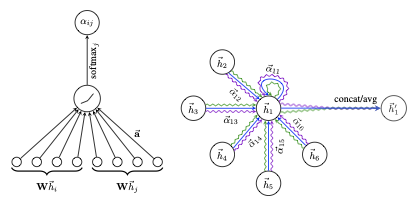

In [ ]:
from torch_geometric.nn import GAT


Epoch: 0
----------
Train loss: 2.7727 | Train acc: 0.0643
  Val loss: 2.7525 |   Val acc: 0.3200

Epoch: 20
----------
Train loss: 2.3696 | Train acc: 0.9929
  Val loss: 2.4239 |   Val acc: 0.7340

Epoch: 40
----------
Train loss: 2.1277 | Train acc: 0.9929
  Val loss: 2.2304 |   Val acc: 0.7440

Epoch: 60
----------
Train loss: 1.9407 | Train acc: 0.9786
  Val loss: 2.0848 |   Val acc: 0.7280

Epoch: 80
----------
Train loss: 1.7001 | Train acc: 0.9714
  Val loss: 1.9467 |   Val acc: 0.6920

Epoch: 100
----------
Train loss: 1.5023 | Train acc: 0.9714
  Val loss: 1.8574 |   Val acc: 0.6620

Epoch: 120
----------
Train loss: 1.3548 | Train acc: 0.9643
  Val loss: 1.7953 |   Val acc: 0.6420

Epoch: 140
----------
Train loss: 1.2457 | Train acc: 0.9643
  Val loss: 1.7499 |   Val acc: 0.6160

Epoch: 160
----------
Train loss: 1.1721 | Train acc: 0.9714
  Val loss: 1.7167 |   Val acc: 0.6060

Epoch: 180
----------
Train loss: 1.1155 | Train acc: 0.9786
  Val loss: 1.6891 |   Val acc: 0.6

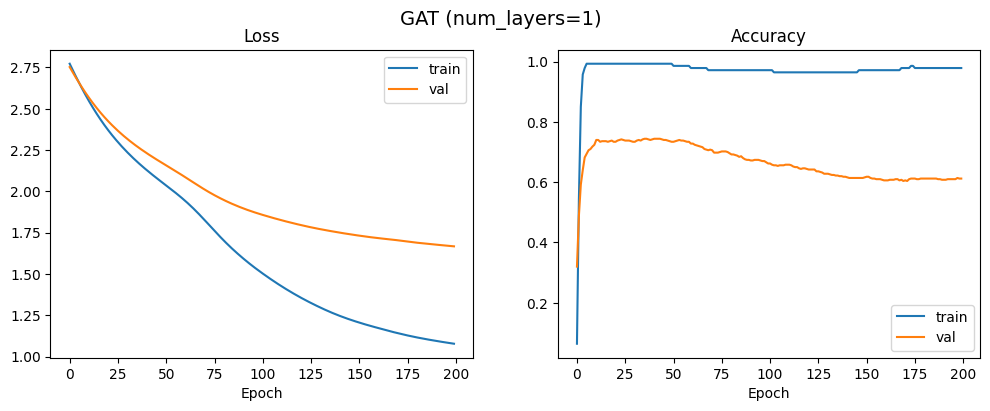

In [ ]:
NUM_LAYERS = 1


model = GAT(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GAT (num_layers={NUM_LAYERS})")

# Attention Mechanism

## Multi-head attention


Epoch: 0
----------
Train loss: 2.7732 | Train acc: 0.0500
  Val loss: 2.7519 |   Val acc: 0.3220

Epoch: 20
----------
Train loss: 2.3705 | Train acc: 0.9929
  Val loss: 2.4240 |   Val acc: 0.7380

Epoch: 40
----------
Train loss: 2.1286 | Train acc: 0.9929
  Val loss: 2.2320 |   Val acc: 0.7280

Epoch: 60
----------
Train loss: 1.9588 | Train acc: 0.9786
  Val loss: 2.0982 |   Val acc: 0.7300

Epoch: 80
----------
Train loss: 1.7855 | Train acc: 0.9714
  Val loss: 1.9812 |   Val acc: 0.6900

Epoch: 100
----------
Train loss: 1.6151 | Train acc: 0.9643
  Val loss: 1.8966 |   Val acc: 0.6460

Epoch: 120
----------
Train loss: 1.4775 | Train acc: 0.9429
  Val loss: 1.8365 |   Val acc: 0.5900

Epoch: 140
----------
Train loss: 1.3624 | Train acc: 0.9571
  Val loss: 1.7906 |   Val acc: 0.5760

Epoch: 160
----------
Train loss: 1.2778 | Train acc: 0.9571
  Val loss: 1.7535 |   Val acc: 0.5660

Epoch: 180
----------
Train loss: 1.2143 | Train acc: 0.9571
  Val loss: 1.7285 |   Val acc: 0.5

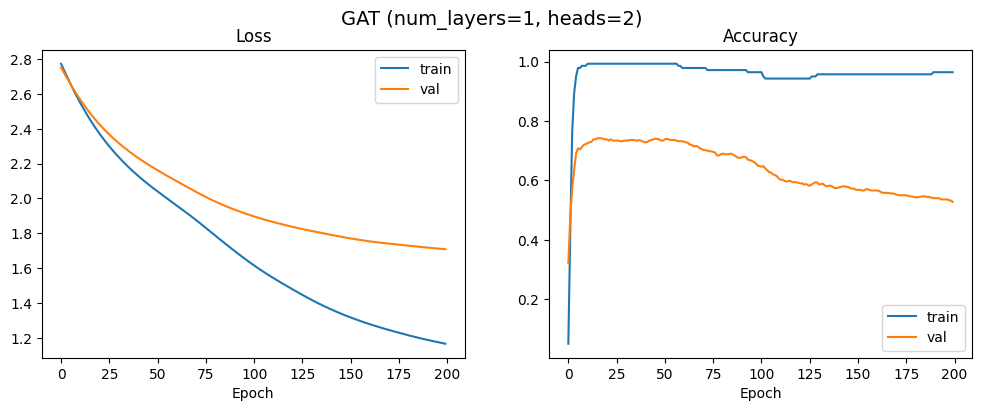

In [ ]:
NUM_LAYERS = 1
HEADS = 2


model = GAT(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, heads=HEADS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GAT (num_layers={NUM_LAYERS}, heads={HEADS})")

# GNN Layer in Practice

## Batch Normalization

In [ ]:
from torch_geometric.nn import BatchNorm


Epoch: 0
----------
Train loss: 2.7721 | Train acc: 0.0643
  Val loss: 2.7517 |   Val acc: 0.3800

Epoch: 20
----------
Train loss: 2.3682 | Train acc: 0.9929
  Val loss: 2.4227 |   Val acc: 0.7340

Epoch: 40
----------
Train loss: 2.1199 | Train acc: 0.9929
  Val loss: 2.2250 |   Val acc: 0.7320

Epoch: 60
----------
Train loss: 1.8943 | Train acc: 0.9714
  Val loss: 2.0653 |   Val acc: 0.6980

Epoch: 80
----------
Train loss: 1.6530 | Train acc: 0.9714
  Val loss: 1.9395 |   Val acc: 0.6740

Epoch: 100
----------
Train loss: 1.4718 | Train acc: 0.9643
  Val loss: 1.8559 |   Val acc: 0.6320

Epoch: 120
----------
Train loss: 1.3346 | Train acc: 0.9571
  Val loss: 1.7958 |   Val acc: 0.6080

Epoch: 140
----------
Train loss: 1.2340 | Train acc: 0.9571
  Val loss: 1.7522 |   Val acc: 0.6020

Epoch: 160
----------
Train loss: 1.1620 | Train acc: 0.9714
  Val loss: 1.7201 |   Val acc: 0.6000

Epoch: 180
----------
Train loss: 1.1102 | Train acc: 0.9786
  Val loss: 1.6909 |   Val acc: 0.6

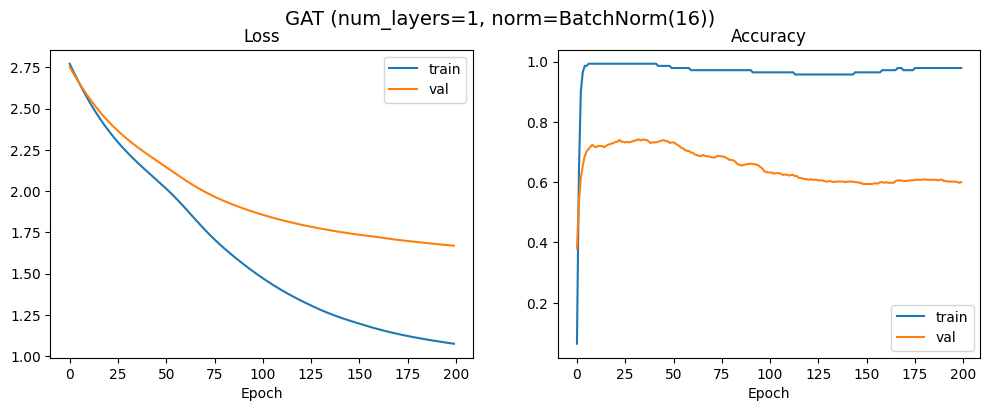

In [ ]:
NUM_LAYERS = 1
NORM = BatchNorm(HIDDEN_CHANNELS)


model = GAT(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, norm=NORM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GAT (num_layers={NUM_LAYERS}, norm={NORM})")

## Dropout


Epoch: 0
----------
Train loss: 2.7709 | Train acc: 0.0857
  Val loss: 2.7513 |   Val acc: 0.3520

Epoch: 20
----------
Train loss: 2.3925 | Train acc: 0.9143
  Val loss: 2.4348 |   Val acc: 0.7320

Epoch: 40
----------
Train loss: 2.1494 | Train acc: 0.9357
  Val loss: 2.2431 |   Val acc: 0.7380

Epoch: 60
----------
Train loss: 1.9803 | Train acc: 0.9071
  Val loss: 2.1079 |   Val acc: 0.7200

Epoch: 80
----------
Train loss: 1.8726 | Train acc: 0.8857
  Val loss: 1.9972 |   Val acc: 0.6940

Epoch: 100
----------
Train loss: 1.6788 | Train acc: 0.8857
  Val loss: 1.9096 |   Val acc: 0.6640

Epoch: 120
----------
Train loss: 1.6155 | Train acc: 0.8214
  Val loss: 1.8440 |   Val acc: 0.6580

Epoch: 140
----------
Train loss: 1.5687 | Train acc: 0.7714
  Val loss: 1.7994 |   Val acc: 0.6480

Epoch: 160
----------
Train loss: 1.5400 | Train acc: 0.7286
  Val loss: 1.7688 |   Val acc: 0.6500

Epoch: 180
----------
Train loss: 1.5295 | Train acc: 0.6786
  Val loss: 1.7473 |   Val acc: 0.6

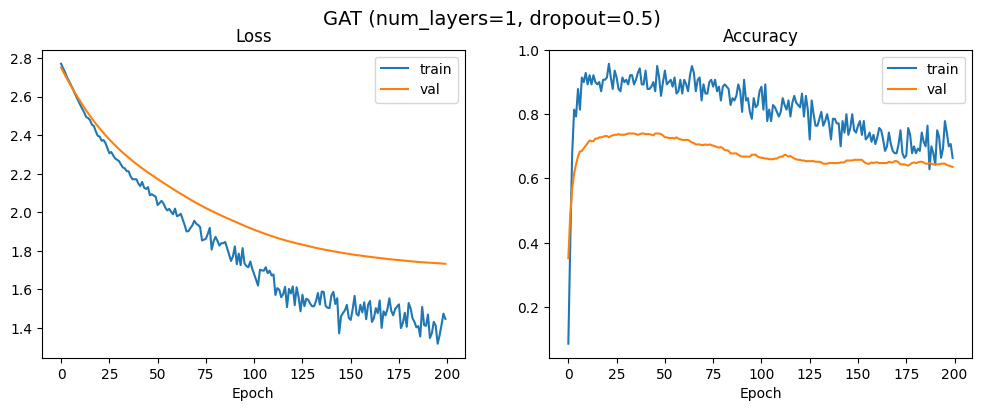

In [ ]:
NUM_LAYERS = 1
DROPOUT = 0.5


model = GAT(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, dropout=DROPOUT).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GAT (num_layers={NUM_LAYERS}, dropout={DROPOUT})")

## Activation (Non-linearity)


Epoch: 0
----------
Train loss: 2.7736 | Train acc: 0.0857
  Val loss: 2.7545 |   Val acc: 0.2600

Epoch: 20
----------
Train loss: 2.3895 | Train acc: 0.9357
  Val loss: 2.4375 |   Val acc: 0.7380

Epoch: 40
----------
Train loss: 2.1688 | Train acc: 0.8929
  Val loss: 2.2482 |   Val acc: 0.7400

Epoch: 60
----------
Train loss: 2.0147 | Train acc: 0.8857
  Val loss: 2.1224 |   Val acc: 0.7440

Epoch: 80
----------
Train loss: 1.8999 | Train acc: 0.9000
  Val loss: 2.0215 |   Val acc: 0.7220

Epoch: 100
----------
Train loss: 1.7695 | Train acc: 0.8571
  Val loss: 1.9210 |   Val acc: 0.6920

Epoch: 120
----------
Train loss: 1.7253 | Train acc: 0.8214
  Val loss: 1.8473 |   Val acc: 0.7000

Epoch: 140
----------
Train loss: 1.6190 | Train acc: 0.8143
  Val loss: 1.8078 |   Val acc: 0.6580

Epoch: 160
----------
Train loss: 1.4999 | Train acc: 0.7571
  Val loss: 1.7671 |   Val acc: 0.6700

Epoch: 180
----------
Train loss: 1.4344 | Train acc: 0.7000
  Val loss: 1.7480 |   Val acc: 0.6

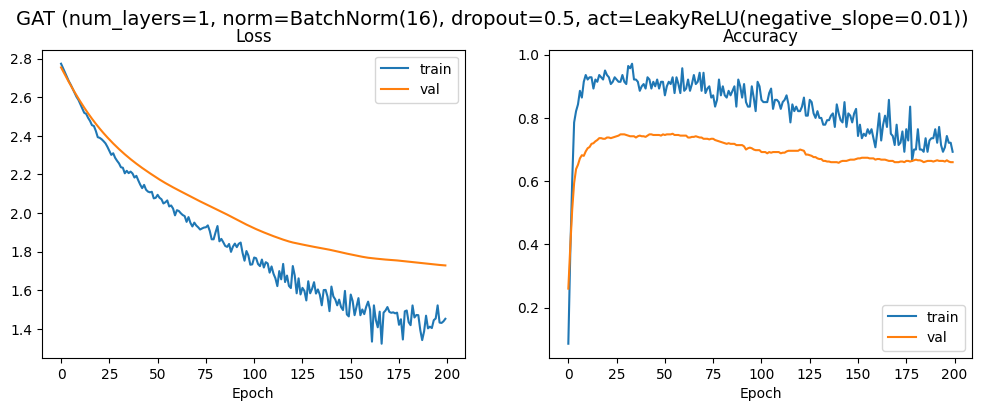

In [ ]:
NUM_LAYERS = 1
NORM = BatchNorm(HIDDEN_CHANNELS)
DROPOUT = 0.5
ACT = torch.nn.LeakyReLU()


model = GAT(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, norm=NORM, dropout=DROPOUT, act=ACT).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GAT (num_layers={NUM_LAYERS}, norm={NORM}, dropout={DROPOUT}, act={ACT})")

# Stacking GNN Layers


Epoch: 0
----------
Train loss: 2.7737 | Train acc: 0.0071
  Val loss: 2.7561 |   Val acc: 0.2140

Epoch: 20
----------
Train loss: 2.1291 | Train acc: 0.4000
  Val loss: 2.0950 |   Val acc: 0.3600

Epoch: 40
----------
Train loss: 1.6640 | Train acc: 0.8071
  Val loss: 1.8130 |   Val acc: 0.5680

Epoch: 60
----------
Train loss: 1.1946 | Train acc: 0.9429
  Val loss: 1.4933 |   Val acc: 0.7300

Epoch: 80
----------
Train loss: 0.6451 | Train acc: 0.9429
  Val loss: 1.1351 |   Val acc: 0.7300

Epoch: 100
----------
Train loss: 0.3958 | Train acc: 0.9643
  Val loss: 1.0404 |   Val acc: 0.7080

Early stopping...

Epoch: 119
----------
Train loss: 0.2594 | Train acc: 0.9929
  Val loss: 1.0281 |   Val acc: 0.6680
 Test loss: 1.0394 |  Test acc: 0.6870


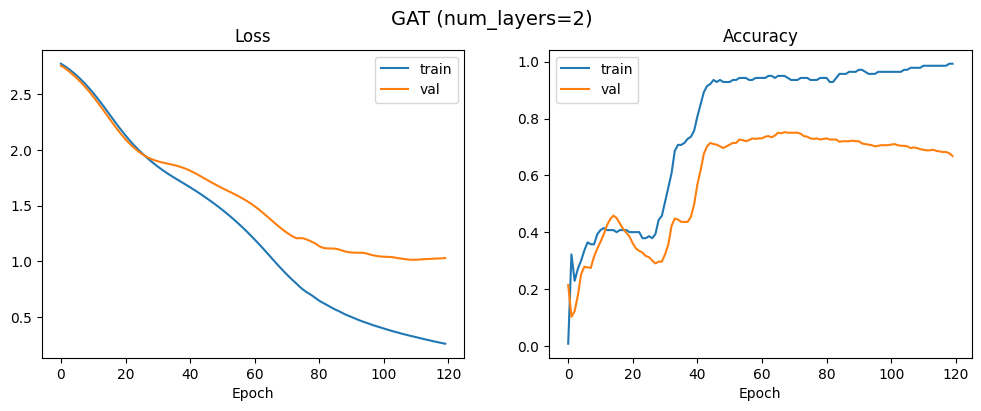

In [ ]:
NUM_LAYERS = 2


model = GAT(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GAT (num_layers={NUM_LAYERS})")

# Expressive Power for Shallow GNNs

In [ ]:
class PrePostProc(torch.nn.Module):
    def __init__(
        self,
        model: torch.nn.Module,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        num_classes: int,
        num_pre_layers: int = 0,
        num_post_layers: int = 0,
        act: Callable[[Tensor], Tensor] = torch.nn.ReLU(inplace=True),
    ) -> None:
        super().__init__()

        self.model = model
        preproc = []
        postproc = []
        if num_pre_layers:
            preproc.append(torch.nn.Linear(in_channels, hidden_channels))
            preproc.append(act)

        for idx in range(num_pre_layers - 1):
            preproc.append(torch.nn.Linear(hidden_channels, hidden_channels))
            preproc.append(act)

        for idx in range(num_post_layers - 1):
            postproc.append(torch.nn.Linear(out_channels, out_channels))
            postproc.append(act)

        if num_post_layers:
            postproc.append(torch.nn.Linear(out_channels, num_classes))

        self.preproc = torch.nn.Sequential(*preproc)
        self.postproc = torch.nn.Sequential(*postproc)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.preproc(x)
        x = self.model(x, edge_index)
        x = self.postproc(x)
        return x


Epoch: 0
----------
Train loss: 1.9516 | Train acc: 0.1429
  Val loss: 1.9569 |   Val acc: 0.0580

Early stopping...

Epoch: 17
----------
Train loss: 1.9459 | Train acc: 0.1429
  Val loss: 1.9478 |   Val acc: 0.1560
 Test loss: 1.9480 |  Test acc: 0.1440


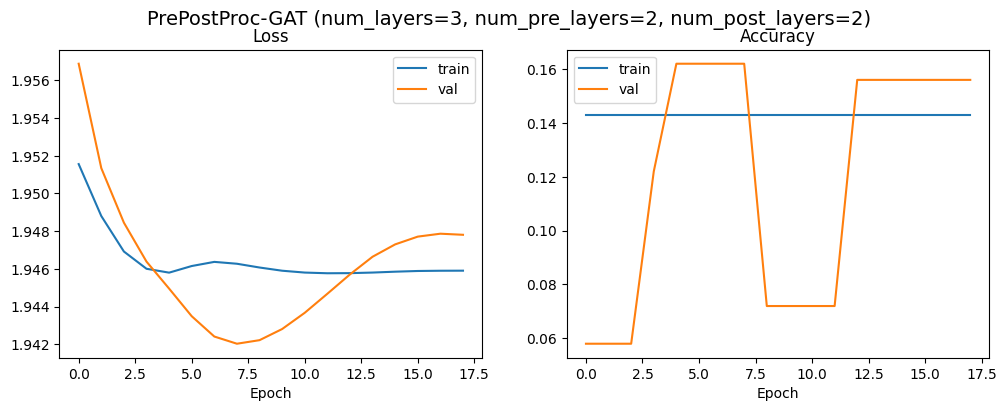

In [ ]:
NUM_LAYERS = 3
NUM_PRE_LAYERS = 2
NUM_POST_LAYERS = 2

model = PrePostProc(
    model=GAT(HIDDEN_CHANNELS, HIDDEN_CHANNELS, NUM_LAYERS, out_channels=HIDDEN_CHANNELS),
    in_channels=dataset.num_node_features,
    hidden_channels=HIDDEN_CHANNELS,
    out_channels=HIDDEN_CHANNELS,
    num_classes=dataset.num_classes,
    num_pre_layers=NUM_PRE_LAYERS,
    num_post_layers=NUM_POST_LAYERS,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(
    history,
    f"PrePostProc-GAT (num_layers={NUM_LAYERS}, num_pre_layers={NUM_PRE_LAYERS}, num_post_layers={NUM_POST_LAYERS})",
)

# Design GNN Layer Connectivity

In [ ]:
from torch_geometric.nn import GCNConv

In [ ]:
class GCNConvBlock(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        act: Optional[Callable[[Tensor], Tensor]] = torch.nn.ReLU(inplace=True),
        norm: Optional[torch.nn.Module] = None,
        normalize: bool = True,
        add_skip: bool = False,
    ) -> None:
        super().__init__()
        self.conv = GCNConv(in_channels, in_channels, normalize=normalize)
        self.norm = copy.deepcopy(norm)
        self.act = act
        self.add_skip = add_skip

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        out = self.conv(x, edge_index)
        if self.norm is not None:
            out = self.norm(out)

        if self.add_skip:
            out += x

        if self.act is not None:
            out = self.act(out)

        return out

# Example: GCN with Skip Connections

In [ ]:
class GCNSkip1(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        num_layers: int,
        out_channels: int,
        dropout: float = 0.0,
        act: Optional[Callable[[Tensor], Tensor]] = torch.nn.ReLU(inplace=True),
        norm: Optional[torch.nn.Module] = None,
        normalize: bool = True,
    ):
        super().__init__()
        self.linear1 = torch.nn.Linear(in_channels, hidden_channels)
        skip_blocks = []
        for _ in range(num_layers):
            skip_blocks.append(
                (
                    GCNConvBlock(hidden_channels, act=act, norm=norm, normalize=normalize, add_skip=True),
                    "x, edge_index -> x",
                )
            )

        self.skip_blocks = Sequential("x, edge_index", modules=skip_blocks)
        self.linear2 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.linear1(x)
        x = self.skip_blocks(x, edge_index)
        x = self.linear2(x)
        return x


Epoch: 0
----------
Train loss: 1.9577 | Train acc: 0.1429
  Val loss: 1.9207 |   Val acc: 0.1620

Epoch: 20
----------
Train loss: 0.9820 | Train acc: 0.7000
  Val loss: 1.4617 |   Val acc: 0.5220

Early stopping...

Epoch: 40
----------
Train loss: 0.0139 | Train acc: 1.0000
  Val loss: 1.5647 |   Val acc: 0.6800
 Test loss: 1.3550 |  Test acc: 0.6980


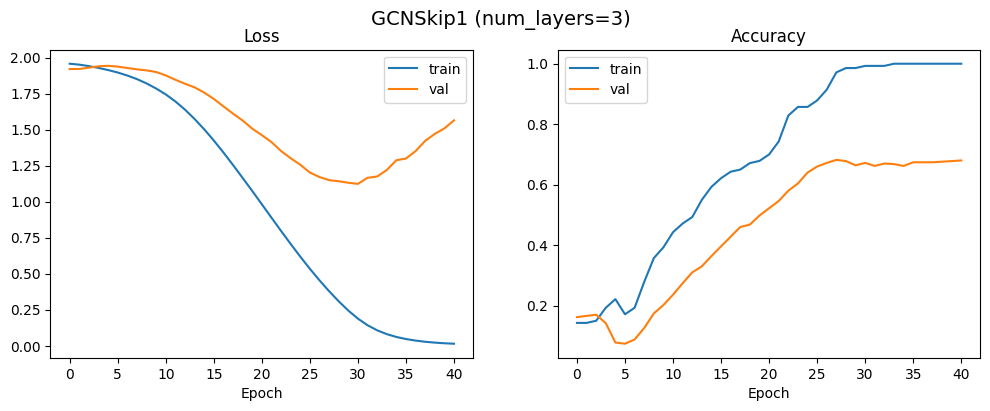

In [ ]:
NUM_LAYERS = 3


model = GCNSkip1(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GCNSkip1 (num_layers={NUM_LAYERS})")

# Other Option of Skip Connections

In [ ]:
class GCNSkip2(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        num_layers: int,
        out_channels: int,
        dropout: float = 0.0,
        act: Optional[Callable[[Tensor], Tensor]] = torch.nn.ReLU(inplace=True),
        norm: Optional[torch.nn.Module] = None,
        normalize: bool = True,
    ):
        super().__init__()
        self.num_layers = num_layers
        self.linear1 = torch.nn.Linear(in_channels, hidden_channels)
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append((GCNConvBlock(hidden_channels, act=act, norm=norm, normalize=normalize)))

        self.linear2 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.linear1(x)
        outs = [x]
        for idx in range(self.num_layers):
            outs.append(self.convs[idx](outs[-1], edge_index))

        x = torch.mean(torch.stack(outs), axis=0)
        x = self.linear2(x)
        return x


Epoch: 0
----------
Train loss: 1.9542 | Train acc: 0.1429
  Val loss: 1.9866 |   Val acc: 0.1220

Epoch: 20
----------
Train loss: 1.7587 | Train acc: 0.6214
  Val loss: 1.8096 |   Val acc: 0.5020

Epoch: 40
----------
Train loss: 0.9126 | Train acc: 0.8571
  Val loss: 1.3611 |   Val acc: 0.5120

Early stopping...

Epoch: 57
----------
Train loss: 0.2849 | Train acc: 0.9857
  Val loss: 1.3065 |   Val acc: 0.5920
 Test loss: 1.3314 |  Test acc: 0.6090


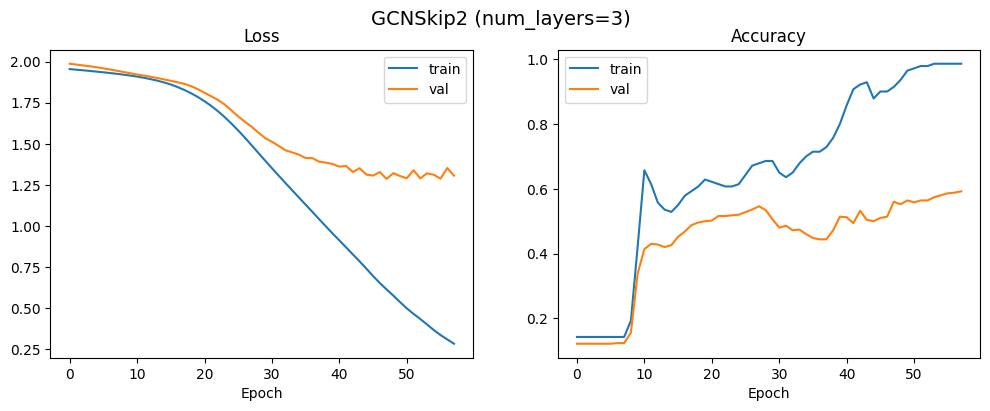

In [ ]:
NUM_LAYERS = 3


model = GCNSkip2(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GCNSkip2 (num_layers={NUM_LAYERS})")